In [1]:
# ==========================================================
# 07_models_baseline.ipynb
# Treina: Logistic Regression, Random Forest, MLP (torch)
# Salva métricas em data/artifacts/results.json
# ==========================================================

# 0) Project setup (path fix for notebooks)
import sys
from pathlib import Path

# Detect project root (works in notebooks and scripts)
if "__file__" in globals():
    ROOT = Path(__file__).resolve().parents[1]
else:
    ROOT = Path.cwd().parents[0]  # assumes this notebook lives in /notebooks

# Add project root to sys.path so `src` can be imported
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

print(f"📁 Project root detected as: {ROOT.resolve()}")


📁 Project root detected as: /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC


In [2]:
# 1) Imports + config
import pandas as pd
from pathlib import Path

from src.utils import ConfigLoader
from src.models.baseline.runner import BaselineRunner
from src.results.store import ResultsStore

# Lê config
cfg = ConfigLoader.load("base.yaml")

data_proc = (ROOT / cfg["paths"]["data_processed"]).resolve()
artifacts = (ROOT / cfg["paths"]["artifacts"]).resolve()
artifacts.mkdir(parents=True, exist_ok=True)

print("data_processed:", data_proc)
print("artifacts     :", artifacts)


data_processed: /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/data/processed
artifacts     : /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/data/artifacts


In [4]:
# 2) Carrega splits tabulares do 03
splits_dir = data_proc / "splits"
df_train = pd.read_csv(splits_dir / "train_nodes.csv")
df_test1 = pd.read_csv(splits_dir / "test1_nodes.csv")
df_test2 = pd.read_csv(splits_dir / "test2_nodes.csv")

print("splits:", df_train.shape, df_test1.shape, df_test2.shape)


splits: (29894, 168) (9983, 168) (6687, 168)


In [5]:
# 3) Define feature sets (Local 1..94, 1-hop 95..166, AF = todos)
def _num(c: str) -> int:
    # "feature_123" -> 123
    return int(c.split("_")[1])

all_feats = [c for c in df_train.columns if c.startswith("feature_")]
local_features = [c for c in all_feats if _num(c) <= 94]
onehop_features = [c for c in all_feats if _num(c) >= 95]
af_features = sorted(all_feats, key=_num)

feature_sets = {
    "Local": local_features,
    "1-hop": onehop_features,
    "AF":    af_features,
}

{ k: (len(v), v[:3]) for k,v in feature_sets.items() }  # sanity peek


{'Local': (94, ['feature_1', 'feature_2', 'feature_3']),
 '1-hop': (71, ['feature_95', 'feature_96', 'feature_97']),
 'AF': (165, ['feature_1', 'feature_2', 'feature_3'])}

# Treinando os modelos

In [6]:
# 4) Executa os 3 modelos (LR, RF, MLP) em 5 seeds por feature set
seed_global = cfg.get("general", {}).get("seed", 42)
seeds = [seed_global + i for i in range(5)]

runner = BaselineRunner(cfg, seeds)
results_summary = runner.run_all(feature_sets, df_train, df_test1, df_test2)

# Estrutura de saída:
# {
#   "logreg": {"Local":[{...},{...},...], "1-hop":[...], "AF":[...]},
#   "rf":     {...},
#   "mlp":    {...}
# }
print("✅ Treino finalizado para: ", list(results_summary.keys()))


✅ Treino finalizado para:  ['logreg', 'rf', 'mlp']


In [8]:
# 5) Persistência em data/artifacts/results.json
store_path = artifacts / "results.json"
store = ResultsStore(store_path)

# Monta payloads por família (logreg / rf / mlp), feature_set e seed
for family_key, model_dict in results_summary.items():
    # params usados (vêm do YAML)
    model_cfg = cfg["baselines"][family_key]

    for feat_name, runs in model_dict.items():
        for r in runs:
            payload = {
                "family": family_key,           # "logreg" | "rf" | "mlp"
                "feature_set": feat_name,       # "Local" | "1-hop" | "AF"
                "seed": r["seed"],
                "train_params": model_cfg,      # guarda os hiperparâmetros usados dessa família
                "metrics": {
                    "global": {
                        "35_42": r["Global (35–42)"],
                        "43_49": r["Global (43–49)"],
                        "35_49": r["Global (35–49)"],
                    },
                    "by_time_step": r["por_time_step"],
                },
            }
            # namespace "baselines" para diferenciar de "skipgcn"
            store.append_run("baselines", payload)

print("💾 Resultados salvos/atualizados em:", store_path)


💾 Resultados salvos/atualizados em: /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/data/artifacts/results.json


# Resultados

In [9]:
# 6) (Opcional) Resumo curto em tela
import numpy as np
import pandas as pd

def mean_std_str(values):
    arr = np.array(values, dtype=float)
    return f"{np.nanmean(arr):.3f} ± {np.nanstd(arr):.3f}"

summary_rows = []
for family_key, model_dict in results_summary.items():
    for feat_name, runs in model_dict.items():
        for label, key in [("Pré (35–42)", "Global (35–42)"),
                           ("Pós (43–49)", "Global (43–49)"),
                           ("Global (35–49)", "Global (35–49)")]:
            summary_rows.append({
                "Família": family_key.upper(),
                "Features": feat_name,
                "Período": label,
                "Gini":   mean_std_str([r[key]["Gini"] for r in runs]),
                "PR-AUC": mean_std_str([r[key]["PR-AUC"] for r in runs]),
                "PR-AUC/Prev": mean_std_str([r[key]["PR-AUC/Prev"] for r in runs]),
                "F1":     mean_std_str([r[key]["F1"] for r in runs]),
                "Recall": mean_std_str([r[key]["Recall"] for r in runs]),
                "Precision": mean_std_str([r[key]["Precision"] for r in runs]),
            })

df_summary_baseline = (
    pd.DataFrame(summary_rows)
      .set_index(["Família","Features","Período"])
      .sort_index()
)

display(df_summary_baseline)


Gini         PR-AUC  \
Família Features       Período                                        
LOGREG  LogReg (1-hop) Global (35–49)  0.723 ± 0.000  0.393 ± 0.000   
                       Pré (35–42)     0.799 ± 0.000  0.553 ± 0.000   
                       Pós (43–49)     0.378 ± 0.000  0.046 ± 0.000   
        LogReg (AF)    Global (35–49)  0.763 ± 0.000  0.292 ± 0.000   
                       Pré (35–42)     0.814 ± 0.000  0.426 ± 0.000   
                       Pós (43–49)     0.506 ± 0.000  0.054 ± 0.000   
        LogReg (Local) Global (35–49)  0.732 ± 0.000  0.252 ± 0.000   
                       Pré (35–42)     0.818 ± 0.000  0.382 ± 0.000   
                       Pós (43–49)     0.281 ± 0.000  0.038 ± 0.000   
MLP     MLP (1-hop)    Global (35–49)  0.713 ± 0.014  0.495 ± 0.048   
                       Pré (35–42)     0.773 ± 0.019  0.586 ± 0.053   
                       Pós (43–49)     0.326 ± 0.029  0.045 ± 0.006   
        MLP (AF)       Global (35–49)  0.824 ± 0.012  0.621 ± 0.032   
                       Pré (35–42)     0.876 ± 0.012  0.740 ± 0.036   
                       Pós (43–49)     0.546 ± 0.057  0.063 ± 0.011   
        MLP (Local)    Global (35–49)  0.830 ± 0.004  0.565 ± 0.071   
                       Pré (35–42)     0.928 ± 0.002  0.777 ± 0.031   
                       Pós (43–49)     0.303 ± 0.013  0.036 ± 0.001   
RF      RF (1-hop)     Global (35–49)  0.777 ± 0.019  0.643 ± 0.005   
                       Pré (35–42)     0.865 ± 0.011  0.796 ± 0.004   
                       Pós (43–49)     0.309 ± 0.072  0.042 ± 0.005   
        RF (AF)        Global (35–49)  0.828 ± 0.006  0.779 ± 0.002   
                       Pré (35–42)     0.935 ± 0.005  0.906 ± 0.003   
                       Pós (43–49)     0.204 ± 0.015  0.044 ± 0.002   
        RF (Local)     Global (35–49)  0.783 ± 0.008  0.755 ± 0.010   
                       Pré (35–42)     0.919 ± 0.005  0.894 ± 0.005   
                       Pós (43–49)     0.016 ± 0.030  0.028 ± 0.002   

                                          PR-AUC/Prev             F1  \
Família Features       Período                                         
LOGREG  LogReg (1-hop) Global (35–49)   6.049 ± 0.000  0.238 ± 0.000   
                       Pré (35–42)      6.045 ± 0.000  0.324 ± 0.000   
                       Pós (43–49)      1.808 ± 0.000  0.074 ± 0.000   
        LogReg (AF)    Global (35–49)   4.497 ± 0.000  0.302 ± 0.000   
                       Pré (35–42)      4.649 ± 0.000  0.412 ± 0.000   
                       Pós (43–49)      2.148 ± 0.000  0.096 ± 0.000   
        LogReg (Local) Global (35–49)   3.880 ± 0.000  0.250 ± 0.000   
                       Pré (35–42)      4.168 ± 0.000  0.354 ± 0.000   
                       Pós (43–49)      1.500 ± 0.000  0.056 ± 0.000   
MLP     MLP (1-hop)    Global (35–49)   7.624 ± 0.735  0.466 ± 0.095   
                       Pré (35–42)      6.402 ± 0.575  0.523 ± 0.104   
                       Pós (43–49)      1.770 ± 0.243  0.033 ± 0.023   
        MLP (AF)       Global (35–49)   9.564 ± 0.486  0.585 ± 0.087   
                       Pré (35–42)      8.085 ± 0.388  0.659 ± 0.096   
                       Pós (43–49)      2.478 ± 0.424  0.020 ± 0.006   
        MLP (Local)    Global (35–49)   8.698 ± 1.098  0.644 ± 0.018   
                       Pré (35–42)      8.486 ± 0.338  0.789 ± 0.007   
                       Pós (43–49)      1.444 ± 0.029  0.026 ± 0.004   
RF      RF (1-hop)     Global (35–49)   9.903 ± 0.084  0.587 ± 0.007   
                       Pré (35–42)      8.692 ± 0.041  0.669 ± 0.009   
                       Pós (43–49)      1.677 ± 0.217  0.054 ± 0.001   
        RF (AF)        Global (35–49)  11.994 ± 0.034  0.790 ± 0.015   
                       Pré (35–42)      9.892 ± 0.030  0.871 ± 0.016   
                       Pós (43–49)      1.727 ± 0.062  0.033 ± 0.000   
        RF (Local)     Global (35–49)  11.622 ± 0.151  0.757 ± 0.004   
                       Pré (35–42)      9.76

/Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/src/utils/visualization.py:114: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_mean = agg["pr_auc_mean"].interpolate().fillna(method="bfill").fillna(method="ffill")


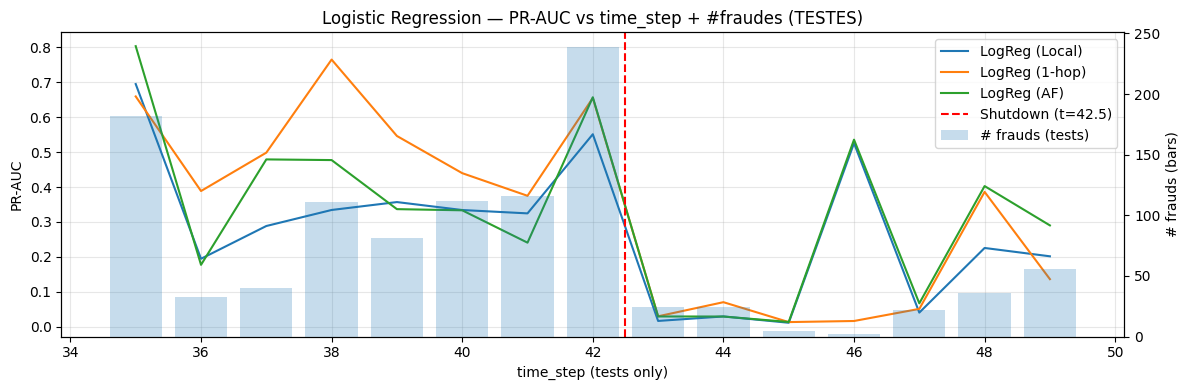

/Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/src/utils/visualization.py:114: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_mean = agg["pr_auc_mean"].interpolate().fillna(method="bfill").fillna(method="ffill")


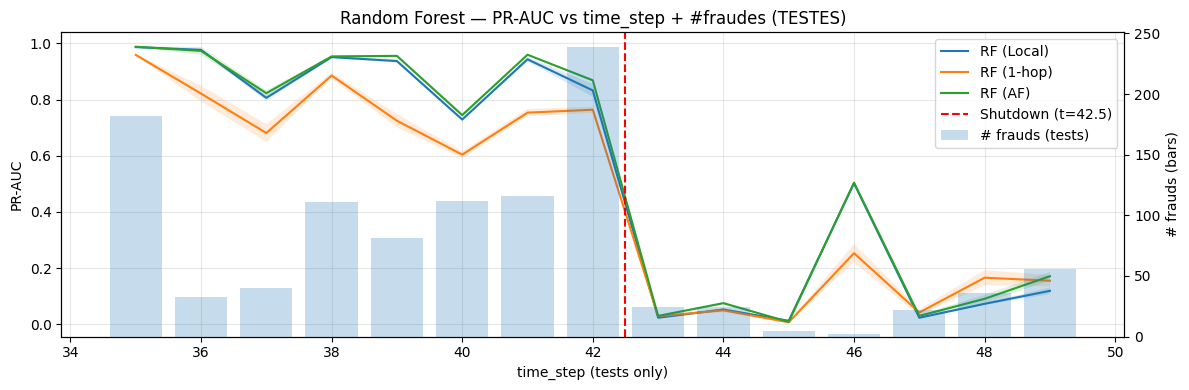

/Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/src/utils/visualization.py:114: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_mean = agg["pr_auc_mean"].interpolate().fillna(method="bfill").fillna(method="ffill")


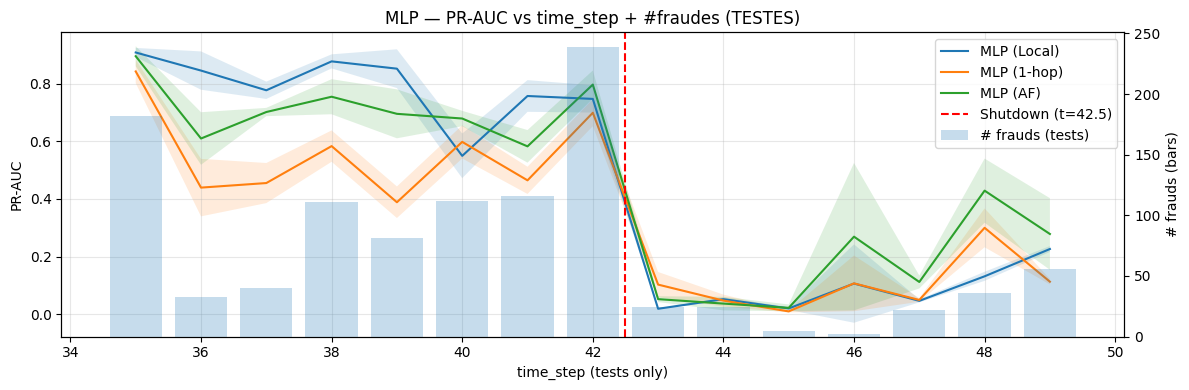

(<Figure size 1200x400 with 2 Axes>,
 <Axes: title={'center': 'MLP — PR-AUC vs time_step + #fraudes (TESTES)'}, xlabel='time_step (tests only)', ylabel='PR-AUC'>)

In [11]:
from src.utils.visualization import Visualization

# 1) Logistic Regression
Visualization.plot_pr_auc_with_fraud_bars(
    results_summary=results_summary["logreg"],
    df_test1=df_test1,
    df_test2=df_test2,
    model_names=["LogReg (Local)", "LogReg (1-hop)", "LogReg (AF)"],
    shutdown_ts=42.5,
    title="Logistic Regression — PR-AUC vs time_step + #fraudes (TESTES)",
)

# 2) Random Forest
Visualization.plot_pr_auc_with_fraud_bars(
    results_summary=results_summary["rf"],
    df_test1=df_test1,
    df_test2=df_test2,
    model_names=["RF (Local)", "RF (1-hop)", "RF (AF)"],
    shutdown_ts=42.5,
    title="Random Forest — PR-AUC vs time_step + #fraudes (TESTES)",
)

# 3) MLP (Torch)
Visualization.plot_pr_auc_with_fraud_bars(
    results_summary=results_summary["mlp"],
    df_test1=df_test1,
    df_test2=df_test2,
    model_names=["MLP (Local)", "MLP (1-hop)", "MLP (AF)"],
    shutdown_ts=42.5,
    title="MLP — PR-AUC vs time_step + #fraudes (TESTES)",
)


/Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/src/utils/visualization.py:114: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_mean = agg["pr_auc_mean"].interpolate().fillna(method="bfill").fillna(method="ffill")


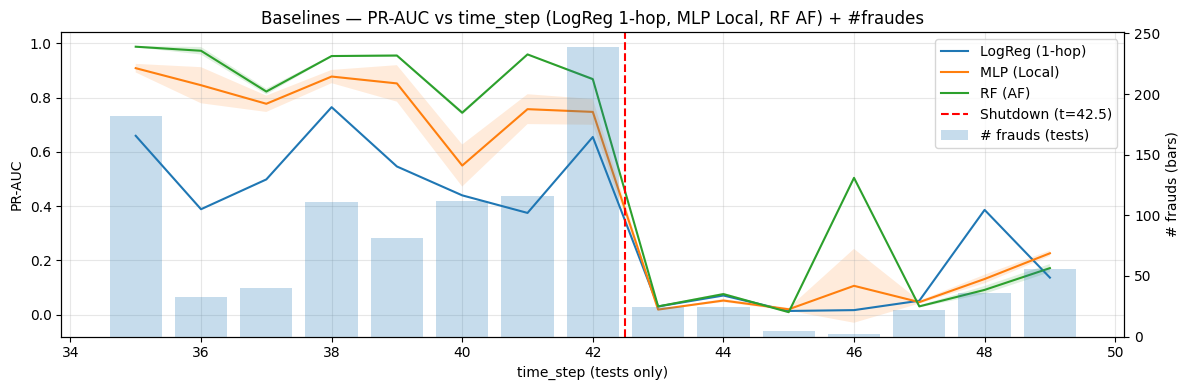

(<Figure size 1200x400 with 2 Axes>,
 <Axes: title={'center': 'Baselines — PR-AUC vs time_step (LogReg 1-hop, MLP Local, RF AF) + #fraudes'}, xlabel='time_step (tests only)', ylabel='PR-AUC'>)

In [12]:
# === PR-AUC vs time_step: LogReg 1-hop vs MLP Local vs RF AF ===
from src.utils.visualization import Visualization

# Monta um dicionário só com os três modelos desejados (cada valor é a lista de runs por seed)
selected_results = {
    "LogReg (1-hop)": results_summary["logreg"]["LogReg (1-hop)"],
    "MLP (Local)":    results_summary["mlp"]["MLP (Local)"],
    "RF (AF)":        results_summary["rf"]["RF (AF)"],
}

# Plota (usa df_test1/df_test2 para o eixo X e barras de fraudes)
Visualization.plot_pr_auc_with_fraud_bars(
    results_summary=selected_results,
    df_test1=df_test1,
    df_test2=df_test2,
    model_names=["LogReg (1-hop)", "MLP (Local)", "RF (AF)"],
    shutdown_ts=42.5,
    title="Baselines — PR-AUC vs time_step (LogReg 1-hop, MLP Local, RF AF) + #fraudes",
)
